# Graph Data Pipeline

The purpose of this notebook is to automate the conversion of tabular data (CSV file) into a heterogeneous or homogeneous graph file (NPZ file). 

The output format of the NPZ file is given such that it is compatible for network embedding models, such as [GLACE](https://arxiv.org/pdf/1912.00536.pdf), [GSNE](https://arxiv.org/pdf/2009.00254.pdf), and [Graph2Gauss](https://arxiv.org/pdf/1707.03815.pdf).

**The notebook is structured as follows**:
(All the steps also encompass the necessary preprocessing of the data used).
1) Creating a homogeneous house-house graph network.
2) Creating a heterogeneous house-school graph network.
3) Creating a general heterogeneous house-house + house-school graph network. (The created graphs of this section haven't been tested and could contain errors)


**The datasets utilized in this notebook are the following**:
- [King County housing data](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/): Contains house sale prices for King county, including Seattle, over time period of May 2014 and May 2015.
- [King County school data](https://www5.kingcounty.gov/sdc/Metadata.aspx?Layer=schsite): Contains King County school sites and school related facilities, including public and private schools. Does not include locations of kindergarten en other pre-school facilities. The data originates from the year 2016.

After constructing a graph and it's NPZ file, it can be feeded into the GLACE or GSNE_adjusted embedding algorithms. 

**!!!!!Make sure to split the graph using the "GLACE/split_data.py" file when utilizing GLACE!!!!!**

### Necessary Packages

In [1]:
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
import os
from geopy.distance import distance
# import statistics
# import geopy
import matplotlib.pyplot as plt
from networkx.algorithms import node_classification
from networkx.algorithms.community.centrality import girvan_newman
from sklearn.preprocessing import MinMaxScaler 
import scipy.sparse as sp


# 1 - Homogeneous graph: House-House

Load in the King County house dataset

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.shape

(21613, 21)

### Exploratory analysis

In [3]:
#Check first 5 rows of dataset
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
#Explore dataframe format
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [5]:
#Check if any column contains null values. If this is the case, remove or replace them.
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Sampling data

Filter out unnecessary data rows/columns and option to take a sample of the data.

In [6]:
# Specific filtering for the King County dataset. 
# Filter out rows that are located in regions with a zipcode far away from Seattle, or located in national parks
outside_zip = [98022,98051,98045,98010,98092,98047,98354,98070,98065,98038,98027,98024,98014,98019,98251,98040,98077,98053]
df = df[~df.zipcode.isin(outside_zip)]
df.shape

(17997, 21)

In [7]:
# Drop unnecessary columns
df.drop(["zipcode"], axis=1, inplace=True)

Only take sample when necessary

In [8]:
#n = sample size
n = 1000
df = df.sample(n=n, random_state=420)
df = df.sort_index()

### Data preprocessing

Duplicates of the same house causes problems during graph creation, only the most recent instance will be kept in the dataset. Duplicates could occur when a house has been sold multiple times within the timeframe.

If duplicates are not removed, the number of nodes and number of attributes will not match.


In [9]:
#Check which rows have a duplicate
df_dup = df.duplicated(subset=['id'], keep = False) 
df_dup = df_dup.loc[lambda x : x == True]
df_dup = pd.DataFrame(df_dup)
indexes_dup = []
for index, row in df_dup.iterrows():
    indexes_dup.append(index)
print(indexes_dup)

[]


Since the most recent information regarding a house has to be kept, all older instances are removed. In the case of the King County dataset, all duplicates are chronologically ordered already. The drop_duplicates function can be used to keep the last occuring house instance. 


In case the instances are not ordered on date, or you're unsure, use the code in the next block instead.

In [10]:
#Remove duplicates
df.drop_duplicates(subset='id', keep='last', inplace=True)

In [500]:
# Can be used in case dates are not ordered
# Will print progress

# for index in indexes_dup:
#     id1 = df.loc[index]['id']
#     recent_date = df.loc[index]['date']
#     print(index)
#     for index2, row2 in df.iterrows():
#         if index2 > index:
#             if id1 == row2['id']:
#                 print('match')
#                 if recent_date > row2['date']:
#                     df.drop(index2, inplace=True)
#                     print('drop second')
#                 else:
#                     df.drop(index, inplace=True)
#                     recent_date = row2['date']
#                     print('drop first')
#                     break

Check number of rows to make sure duplicates are deleted

In [10]:
df.shape

(1000, 21)

Reassign indexes to avoid problems later on in the pipeline

In [11]:
df = df.reset_index()
df['index'] = df.index
df.head()

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,0,6300000287,20140609T000000,410000.0,3,1.00,1410,5060,1.0,0,...,4,7,910,500,1956,0,47.7073,-122.340,1130,5693
1,1,2767603505,20140507T000000,519950.0,3,2.25,1170,1249,3.0,0,...,3,8,1170,0,2014,0,47.6722,-122.381,1350,1310
2,2,1777500060,20140708T000000,527700.0,5,2.50,2820,9375,1.0,0,...,4,8,1550,1270,1968,0,47.5707,-122.128,2820,9375
3,3,1432900240,20150508T000000,205000.0,3,1.00,1610,8579,1.0,0,...,4,7,1010,600,1962,0,47.4563,-122.171,1610,8579
4,4,3261020370,20140605T000000,653000.0,3,2.50,2680,9750,1.0,0,...,4,8,1610,1070,1979,0,47.7028,-122.231,2480,8750


Preprocessing of date features, depends on personal preference. 

Looking at the King County dataset, it could be useful to transform the date column to seperate columns.

We opted to exclude the date feature since this lowered the embedding performance.

In [12]:
# df["date"] = pd.to_datetime(df["date"])
# df["year"] = df["date"].dt.year
# df["month"] = df["date"].dt.month
# df["day"] = df["date"].dt.day
df = df.drop(["date"], axis=1)
df

,index,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,0,6300000287,410000.0,3,1.00,1410,5060,1.0,0,0,4,7,910,500,1956,0,47.7073,-122.340,1130,5693
1,1,2767603505,519950.0,3,2.25,1170,1249,3.0,0,0,3,8,1170,0,2014,0,47.6722,-122.381,1350,1310
2,2,1777500060,527700.0,5,2.50,2820,9375,1.0,0,0,4,8,1550,1270,1968,0,47.5707,-122.128,2820,9375
3,3,1432900240,205000.0,3,1.00,1610,8579,1.0,0,0,4,7,1010,600,1962,0,47.4563,-122.171,1610,8579
4,4,3261020370,653000.0,3,2.50,2680,9750,1.0,0,0,4,8,1610,1070,1979,0,47.7028,-122.231,2480,8750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,3624039183,315000.0,3,2.50,1480,1590,2.0,0,0,3,8,1150,330,2010,0,47.5302,-122.362,1480,5761
996,996,1760650900,337500.0,4,2.50,2330,4907,2.0,0,0,3,7,2330,0,2013,0,47.3590,-122.081,2300,3836
997,997,1245002281,1050000.0,4,3.75,3280,11000,2.0,0,0,3,10,2320,960,2008,0,47.6855,-122.201,2400,8351
998,998,1972201967,520000.0,2,2.25,1530,981,3.0,0,0,3,8,1480,50,2006,0,47.6533,-122.346,1530,1282


Using a scaler is necessary for machine learning models, such that:
- Different units of measurement do not cause issues during model training.
- Avoid disproportionate impact of outliers on model's predictions.

Specifically for network embedding models it is useful to utilize the MinMaxScaler to have the values in [0,1], since it is prone to gradient explosion.
This is in line with the graph files examined in the scientific literature.

In [13]:
# Exclude columns that should not be processed by the MinMaxScaler
excluded_cols = ["index","id", "price", "lat", "long"]
cols_to_scale = [col for col in df.columns if col not in excluded_cols]
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df.head()

,index,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,0,6300000287,410000.0,0.090909,0.190476,0.107549,0.013805,0.0,0.0,0.0,0.75,0.285714,0.073871,0.142857,0.491228,0.0,47.7073,-122.340,0.150460,0.055798
1,1,2767603505,519950.0,0.090909,0.428571,0.082730,0.001627,1.0,0.0,0.0,0.50,0.428571,0.109439,0.000000,1.000000,0.0,47.6722,-122.381,0.199865,0.007206
2,2,1777500060,527700.0,0.151515,0.476190,0.253361,0.027594,0.0,0.0,0.0,0.75,0.428571,0.161423,0.362857,0.596491,0.0,47.5707,-122.128,0.529980,0.096619
3,3,1432900240,205000.0,0.090909,0.190476,0.128232,0.025050,0.0,0.0,0.0,0.75,0.285714,0.087551,0.171429,0.543860,0.0,47.4563,-122.171,0.258253,0.087794
4,4,3261020370,653000.0,0.090909,0.476190,0.238883,0.028792,0.0,0.0,0.0,0.75,0.428571,0.169631,0.305714,0.692982,0.0,47.7028,-122.231,0.453627,0.089690


### Create homogeneous graph

- Create the graph based on the latitude and longitude coordinates of the preprocessed dataframe. 

- Nodes should contain information on its index, position and node type.

Note: Running this section could take a significant amount of time!

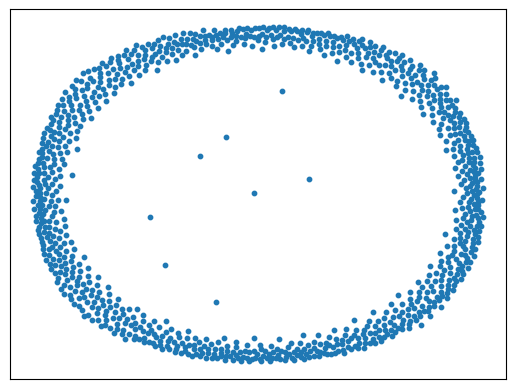

In [14]:
G = nx.Graph()
for index,row in df.iterrows():
    G.add_node(index, pos=(row["lat"], row["long"]), node_type="house")
nx.draw_networkx(G, with_labels=False, node_size = 10)

Generate edges between nodes, based on user-specified distance threshold.
If a connection is not formed within the distance threshold for a node, then an edge is created with its closest neighbour.
This is to avoid dangling nodes and is in line with the approach of [Das et al. (2021)](https://arxiv.org/pdf/2009.00254.pdf).

Dangling nodes are avoided because this causes assertion errors in network embedding models, such as GSNE and GLACE.

Every edge saves the inverse distance as its weight, which can be used in the embedding algorithm.

Note: Building the edges takes a lot of time!


In [15]:
threshold = 1 # kilometers

# Loop over all pairs of nodes and add an edge if their distance is below the threshold
i = 1
for u, u_data in G.nodes(data=True):
    print(i)
    i += 1
    for v, v_data in G.nodes(data=True):
        if u < v:
            u_pos = u_data['pos']
            v_pos = v_data['pos']
            dist = distance(u_pos, v_pos).km
            if dist <= threshold:
                if dist != 0:
                    G.add_edge(u, v, weight=1/dist)
                else:
                     G.add_edge(u, v, weight=1/0.0001)
    #Make sure each node has atleast one 
    if G.degree[u] < 1:
        closest_dist = 1000 #arbitrary number
        closest_node = 0
        
        for v, v_data in G.nodes(data=True):
            if u != v: #Has to stay like this, otherwise will not check rows with lower index on distance
                    u_pos = u_data['pos']
                    v_pos = v_data['pos']
                    dist = distance(u_pos, v_pos).km
                    if dist < closest_dist:
                        closest_dist = dist
                        closest_node = v
        if closest_dist != 0:
            G.add_edge(u, closest_node, weight=1/dist)
        else:
            G.add_edge(u, closest_node, weight=1/0.0001)
        print(closest_dist)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
2.565551390492264
17
18
19
1.329112433387659
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
1.216452718713823
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
1.0928694893460928
61
62
63
1.5348720984012505
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
1.1031877443797375
118
119
120
121
122
123
124
125
126
127
1.390398387424512
128
129
130
131
132
133
134
135
1.3040948560454542
136
137
138
139
1.053341176656
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
1.2524238168694524
155
156
1.1109596583156724
157
158
159
160
161
162
163
164
165
166
167
168
169
1.0482290862128263
170
171
172
173
1.0420083218398197
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
2

Check for duplicate nodes based on the coordinates of the nodes, networkx creates duplicates for houses that have a slight difference in (latitude, longitude) values 

**ONLY RUN IF ERRORS OCCUR**

In [ ]:
# unique_nodes = set() # Represents an unordered set of unique elements. 
# for node, data in G.nodes(data=True):
#     unique_nodes.add((data['pos'], data['node_type'])) # Adding to a set makes it only retain the unique elements based on the position (lat, long).
# print("Unique nodes:", len(unique_nodes))
# print("Total nodes: ", len(G.nodes()))


In [ ]:
# from collections import defaultdict

# # Step 1: Count nodes by their attributes and identify duplicates
# node_count = defaultdict(list)
# for node, data in G.nodes(data=True):
#     node_count[(data['pos'], data['node_type'])].append(node)

# duplicates = {k: v for k, v in node_count.items() if len(v) > 1}

# # Step 2: Print duplicate nodes
# print("Duplicate nodes:")
# for k, v in duplicates.items():
#     print(f"Nodes {v} have the same attributes: {k}")

# # Step 3: Remove duplicate nodes from the graph
# for nodes in duplicates.values():
#     nodes_to_remove = nodes[1:]  # Keep the first node, remove the rest
#     G.remove_nodes_from(nodes_to_remove)

# # Step 4: Remove corresponding rows from the DataFrame
# duplicate_indices = [node for nodes in duplicates.values() for node in nodes[1:]]
# df = df[~df.index.isin(duplicate_indices)]
# print(duplicate_indices)
# # Verify if the duplicates have been removed
# remaining_nodes = [n for n, d in G.nodes(data=True)]
# for nodes in duplicates.values():
#     duplicate_nodes = nodes[1:]
#     for node in duplicate_nodes:
#         if node in remaining_nodes:
#             print(f"Node {node} was not removed.")
#         else:
#             print(f"Node {node} has been successfully removed.")

Check if nodes are created for all the rows of the dataframe.

In [16]:
print(G.number_of_nodes(), "=", df.shape[0])


1000 = 1000


Visualization of the homogeneous house-house graph.

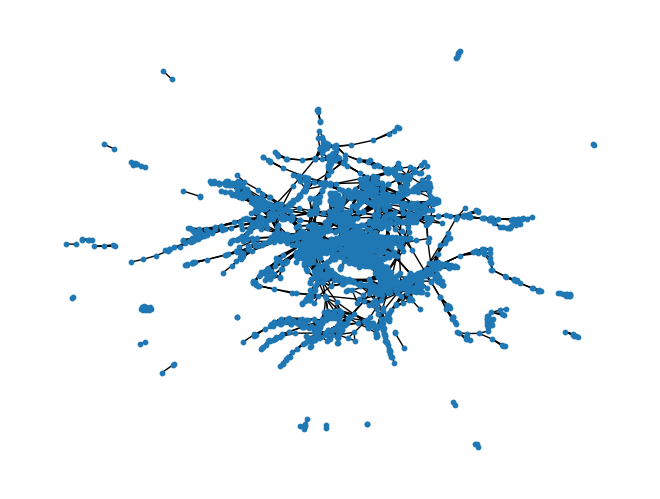

In [515]:
nx.draw(G, node_size=10)

Following code can be useful to remove edges in case mistakes were made

In [516]:
# Usefull for reset of edges
# G.remove_edges_from(list(G.edges()))
# print(G.edges())

The created graph needs to satisfy the following conditions:


1) It cannot have self-loops, in other words the diagonal of the adjacency matrix must contain zero values. Self-loops only occur if there are multiple instances of the same node in the dataframe. If duplicate instances of houses are filtered out then this should not be an issue.
2) There cannot be any dangling nodes, every node needs to be connected in the graph. Dangling nodes occur if only a distance-threshold is utilized without the constraint of forcing nodes to form a connection with its nearest node.

In [17]:
# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))
# Remove dangling nodes
dangling_nodes_orig = [node for node in G.nodes() if not G.degree[node] >0]
print(dangling_nodes_orig) # Print list of dangling nodes
G.remove_nodes_from(list(nx.isolates(G)))

[]


The dangling nodes that are removed from the graph also have to be filtered out of the attribute matrix which contains the features of each node.

In [18]:
mask = np.isin(df['index'], dangling_nodes_orig)
df = df[~mask]
labels = df['price'] #Save prices of leftover rows
df.shape
#df.drop([2313], inplace=True) #Can be used to drop specific row

(1000, 20)

The dataframe containing the raw data can be saved as a CSV file to be used in the model building as raw features. Important to not forget this step! 

In [20]:
df.to_csv("Raw_HouseData.csv")

### Save graph in required format

To save the graph in the required .NPZ format, two sparse matrices must be created:
1) Sparse adjacency matrix: Represents the graph connectivity of nodes and weights of the edges.
2) Sparse attribute matrix: Encompasses attribute data of the nodes.

In [19]:
A = nx.to_scipy_sparse_matrix(G).astype("float32")
print(A)

  (0, 400)	1.2449192
  (0, 431)	1.106541
  (0, 500)	1.0984207
  (1, 215)	1.3438926
  (1, 342)	1.0675067
  (1, 512)	1.2715946
  (1, 675)	1.1013169
  (1, 721)	1.1558102
  (1, 766)	1.2565773
  (1, 940)	1.2052124
  (1, 944)	1.4599345
  (1, 948)	1.4777678
  (1, 952)	3.4835851
  (1, 972)	8.590349
  (1, 975)	1.0538625
  (2, 166)	13.290385
  (2, 274)	1.8560765
  (2, 331)	1.180537
  (2, 362)	1.615363
  (2, 634)	1.2545538
  (2, 812)	1.8750662
  (3, 110)	1.4133576
  (3, 211)	1.2614521
  (3, 297)	1.7953199
  (3, 417)	1.1876837
  :	:
  (995, 662)	1.057723
  (995, 703)	1.1445382
  (995, 707)	1.9950644
  (996, 289)	1.2943981
  (996, 325)	2.456518
  (996, 414)	1.5690246
  (996, 607)	1.3975513
  (996, 902)	4.284691
  (997, 20)	2.911067
  (997, 254)	4.257063
  (997, 366)	2.0647192
  (997, 530)	2.5425372
  (997, 537)	1.5036931
  (998, 535)	2.5697534
  (998, 689)	1.1229742
  (998, 946)	1.0442408
  (998, 950)	10000.0
  (999, 131)	3.3974757
  (999, 265)	1.2180223
  (999, 266)	1.7877736
  (999, 517)	1.450682

Assertion error check to see if there are dangling nodes. The code below should return an empty array

In [20]:
print(np.where(A.sum(0).A1 + A.sum(1).A1 == 0))

(array([], dtype=int64),)


Creating the sparse attribute matrix

In [21]:
# Remove features that do not represent features of the house itself and the target variable
df_cleaned = df.drop(["index","id", "price", "lat", "long"], axis=1, inplace=False)

In [22]:
df_numpy = df_cleaned.to_numpy()
attr_matrix = csr_matrix(df_numpy).astype("float32")
attr_matrix

<1000x15 sparse matrix of type '<class 'numpy.float32'>'
	with 11018 stored elements in Compressed Sparse Row format>

Below code shows the contents of the attribute matrix, if requested.

In [29]:
# attr_array = attr_matrix.toarray()
# print("attr_array:")
# print(attr_array)

attr_array:
[[0.33333334 0.03571429 0.07438895 ... 0.         0.18367347 0.03264866]
 [0.5        0.25       0.24973433 ... 0.         0.3392857  0.02840349]
 [0.33333334 0.03571429 0.05526036 ... 0.         0.09948979 0.07826797]
 ...
 [0.33333334 0.21428572 0.10839532 ... 0.         0.21428572 0.00472847]
 [0.5        0.25       0.28034008 ... 0.         0.5237245  0.03820005]
 [0.16666667 0.         0.05738576 ... 0.         0.10204082 0.00885609]]


### Saving the graph as a .NPZ file

**IF GLACE EMBEDDING ALGORITHM WILL BE USED**: The graph file does not need to be enumerated, it does not have to take the amount of node types into consideration. 

NOTE: This is the only on that was tested

In [ ]:
np.savez('GLACE/graph_house.npz', edges = G.edges, adj_data=A.data, adj_indices=A.indices, adj_indptr=A.indptr,
         adj_shape=A.shape, attr_data1=attr_matrix.data, attr_indices1=attr_matrix.indices, attr_indptr1=attr_matrix.indptr,
         attr_shape1=attr_matrix.shape,labels = labels)

**IF GSNE EMBEDDING ALGORITHM WILL BE USED**: The graph file must be saved in the following format. The numeration of attribute data to save depends on the amount of node types that are going to be present in the general graph file, i.e. here only two node types are going to be used (houses and schools) so "attr_data1" and "attr_data2" must both be present, even if one of the two is empty.


In [30]:
# Save house-house graph
np.savez('GSNE_adjusted/Graph1.npz', edges = G.edges, adj_data=A.data, adj_indices=A.indices, adj_indptr=A.indptr,
         adj_shape=A.shape, attr_data1=attr_matrix.data, attr_indices1=attr_matrix.indices, attr_indptr1=attr_matrix.indptr,
         attr_shape1=attr_matrix.shape, attr_data2=None, attr_indices2=None, attr_indptr2 = None,
         attr_shape2=None,labels = labels)

Below code shows the content of the .NPZ file.

In [532]:
# data = np.load('GLACE/data/cora_ml/Full_graph_sample_price1.npz')

# # Print the keys in the file
# print('Keys in the file:', data.keys())

# # Print the values for each key
# for key in data.keys():
#     print('Data for key', key)
#     print(data[key])

## Save target variable

The target variable must be saved in a separate CSV file to be utilized when machine learning models will be employed.

In [23]:
price_file = pd.DataFrame(labels)
price_file["index"] = price_file.index
price_file = price_file.rename(columns={"Unnamed: 0": "index"})
price_file.to_csv("GSNE_adjusted/price.csv", index=False)
price_file.to_csv("GLACE/price.csv", index=False)

In [24]:
price_file.head()

,price,index
0,410000.0,0
1,519950.0,1
2,527700.0,2
3,205000.0,3
4,653000.0,4


# 2 - Heterogeneous graph: House-School

### Load in school data

In [34]:
school_df = pd.read_csv("kc_school_data.csv")
school_df.head()

,X,Y,OBJECTID,FEATURE_ID,ESITE,CODE,FEATUREDES,NAME,ABB_NAME,ADDRESS,ZIPCODE,LONG_CEN,LAT_CEN,OSPI_CODE,SCH_CLASS,DISTRICT,PIN,MAJOR,MINOR
0,-122.190071,47.258406,1,10000066,1340665.0,660,School-Elementary,Bowman Creek Elementary School,Bowman Creek,5701 Kersey Way SE,98092,-122.190075,47.258404,0.0,10,AUBURN,3221059058,322105,9058
1,-122.176312,47.610853,2,10000076,1258412.0,660,School-Elementary,Wilburton Elementary,Wilburton,12300 Main St,98005,-122.176314,47.610851,0.0,10,BELLEVUE,3325059019,332505,9019
2,-122.299211,47.477355,3,10000077,751890.0,661,School-Junior High/Middle,Glacier Middle School,Glacier,2450 S 142nd St,98168,-122.299213,47.477353,0.0,10,HIGHLINE,3598600006,359860,6
3,-122.170580,47.604033,4,2156,83.0,664,School-Alternative,International School,International,445 128th Ave SE,98005,-122.170582,47.604031,3522.0,10,BELLEVUE,3325059117,332505,9117
4,-122.284831,47.634078,5,940,426089.0,660,School-Elementary,McGilvra Elementary School,McGilvra,1617 38th Ave E,98112,-122.284833,47.634076,2201.0,10,SEATTLE,5318100820,531810,820


In [537]:
school_df.shape

(655, 19)

Only run if you want to sample the POI according to zipcode as well. Hasn't been done in our research

In [35]:
# school_df = school_df[school_df['ZIPCODE'].isin(outside_zip)]
# school_df.shape

(100, 19)

### Create heterogeneous graph

Graph creation is based on the previously created house-house graph. Nodes are copied onto a new graph in order to be more time efficient. Next the school nodes are created in a seperate graph. Afterwards, the nodes of both graphs are combined and given their node_type  and edges are added. Most of the code is in line with what has been done in the previous section

IF BY ACCIDENT THE PREVIOUSLY CREATED GRAPH INSTANCE WAS RESET, LOAD THE HOUSE-HOUSE GRAPH USING FOLLOWING CODE!

In [ ]:
# with np.load("Graph_new_index_inverse.npz", allow_pickle=True) as loader:
#     loader = dict(loader)
#     # Variables of the loader
#     print(loader.keys())
#     A = sp.csr_matrix((loader['adj_data'], loader['adj_indices'],
#                         loader['adj_indptr']), shape=loader['adj_shape'])
#     g = nx.from_scipy_sparse_matrix(A, create_using=nx.DiGraph())

In [ ]:
# #Used to retrieve lat and long features
# basedata = pd.read_csv("BaseKcInverse.csv")
# basedata
# for index, row in basedata.iterrows():
#     lat = row["lat"]
#     long = row["long"]
#     G.nodes[index]["pos"] = (lat,long)

Adjust the indices of school data in order to make sure all indices of houses and schools are unique.

In [40]:
start = len(df_cleaned)
stop = start + len(school_df)
school_df.index = pd.RangeIndex(start = start, stop = stop, step = 1)
school_df.head()

Overlapping node IDs: {0, 202, 55, 535}


Create graph

In [36]:
G_schools = nx.Graph()
for index,row in school_df.iterrows():
    G_schools.add_node(index, pos=(row["LAT_CEN"], row["LONG_CEN"]), node_type="school")

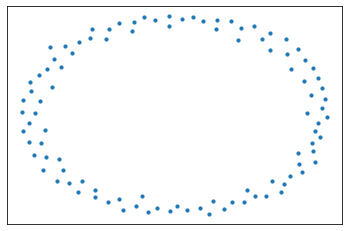

In [37]:
#Graph with only schools
nx.draw_networkx(G_schools, with_labels=False, node_size=10)

In [38]:
print("number of schools: ", len(G_schools.nodes()))
print("number of houses: ", len(G.nodes()))
print("total number of nodes: ", len(G_schools.nodes()) + len(G.nodes()))

number of schools:  100
number of houses:  1000
total number of nodes:  1100


In [41]:
threshold = 10 # kilometers
G_het = nx.Graph()

# Ensure that there is no indices overlap
offset = max(G.nodes()) + 1

for u, u_data in G.nodes(data=True):
    G_het.add_node(u, pos=u_data['pos'], node_type="house")

for v, v_data in G_schools.nodes(data=True): 
    #new_v = v  + offset
    G_het.add_node(v, pos=v_data['pos'], node_type="school")

# The code below checks if the overlap between node IDs has caused nodes to be unnecessarily be dropped from houses. 
node_types = nx.get_node_attributes(G_het, "node_type")
type_count = {}

for node_type in node_types.values():
    if node_type in type_count:
        type_count[node_type] += 1
    else:
        type_count[node_type] = 1
print(type_count)

# Add edges between nodes within threshold distance
for u, u_data in G.nodes(data=True):
    for v, v_data in G_schools.nodes(data=True):
        #new_v = v + offset
        u_pos = u_data['pos']
        v_pos = v_data['pos']
        dist = distance(u_pos, v_pos).km
        if dist <= threshold:
            if dist != 0:
                G_het.add_edge(u, v, weight=1/dist)
            else:
                G_het.add_edge(u, v, weight=1/0.0001)
    if G_het.degree[u] < 1:
        closest_dist = 10000 #arbitrary number
        closest_node = 0
        for v, v_data in G_schools.nodes(data=True):
                #new_v = v + offset
                u_pos = u_data['pos']
                v_pos = v_data['pos']
                dist = distance(u_pos, v_pos).km
                if dist < closest_dist:
                    closest_dist = dist
                    closest_node = v
        if closest_dist != 0:
            G_het.add_edge(u, closest_node, weight=1/dist)
        else:
            G_het.add_edge(u, closest_node, weight=1/0.0001)


{'house': 1000, 'school': 100}
10.746120319242376
17.089363046893816
16.79290273049195
11.92526316230231
12.956740003275646
16.984465042070887
21.101239229114682
13.058896346588298
10.581455894387359
16.487420869845693
10.955611479629702
14.529582360289545
12.514680165757126
13.194438772131985
14.70959526508869
15.056302041287141
16.30749444761898
18.686325316739108
15.798560130309454
16.965453592467913
12.383234294395812
18.81923024824457
17.703782343777604
12.107963242362803
12.217922579549857
12.136551868174541
14.362632169909235
12.256640532835288
20.64411198118193
10.758040944104883
14.970438707946554
11.077001374531896
13.292016408476128
10.858583803955817
17.208873227618746
17.796886062439167
15.7153081104864
10.926685946782886
11.973802885463146
16.607312706962958
13.444906545262326
19.689139450621106
11.899143108717343
15.46754506836571
10.406773991259618
22.0910365658411
10.583514591997327
17.678552272027652
10.79383229416433
17.981717957678285
18.339277130535653
16.304386443

Connect all schools to at least 1 house. Necessary step due to problems with indices

In [ ]:
for v, v_data in G_het.nodes(data=True):
    if v_data['node_type'] == 'school':
        if G_het.degree[v] < 1:
            v_pos = v_data['pos']
            closest_dist = 1000
            closest_node = 0
            for u, u_data in G_het.nodes(data=True):
                if u_data['node_type'] == 'house':
                    #new_v = v + offset
                    u_pos = u_data['pos']
                    dist = distance(u_pos, v_pos).km
                    if dist < closest_dist:
                        closest_dist = dist
                        closest_node = u
            if closest_dist != 0:
                G_het.add_edge(v, closest_node, weight=1/dist) #Nagaan of 1/dist iets doet
            else:
                G_het.add_edge(v, closest_node, weight=1/0.0001)
            print(v,closest_node,closest_dist)

FOLLOWING CODE IS EXPERIMENTAL, IT ALSO CREATES SCHOOL-SCHOOL CONNECTIONS

In [ ]:
# threshold = 10 # kilometers
# G_het = nx.Graph()

# # Ensure that there is no indices overlap
# offset = max(G.nodes()) + 1

# for u, u_data in G.nodes(data=True):
#     G_het.add_node(u, pos=u_data['pos'], node_type="house")

# for v, v_data in G_schools.nodes(data=True): 
#     #Aangepast since incices have been adjusted
#     #new_v = v  + offset
#     G_het.add_node(v, pos=v_data['pos'], node_type="school")

# # The code below checks if the overlap between node IDs has caused nodes to be unnecessarily be dropped from houses. 
# node_types = nx.get_node_attributes(G_het, "node_type")
# type_count = {}

# for node_type in node_types.values():
#     if node_type in type_count:
#         type_count[node_type] += 1
#     else:
#         type_count[node_type] = 1
# print(type_count)


# # Add edges between schools within threshold distance
# for v1, v1_data in G_schools.nodes(data=True):
#     for v2, v2_data in G_schools.nodes(data=True):
#         if v1 == v2:
#             continue
#         v1_pos = v1_data['pos']
#         v2_pos = v2_data['pos']
#         dist = distance(v1_pos, v2_pos).km
#         if dist <= threshold:
#             G_het.add_edge(v1, v2, weight=1/dist)
#         # Nagaan of het nodig is om school-school connections te forcen
#         # elif dist == 0:
#         #     G_het.add_edge(v1, v2, weight=1/0.0001)

# # add edges between nodes within threshold distance
# for u, u_data in G.nodes(data=True):
#     for v, v_data in G_schools.nodes(data=True):
#         #new_v = v + offset
#         u_pos = u_data['pos']
#         v_pos = v_data['pos']
#         dist = distance(u_pos, v_pos).km
#         if dist <= threshold:
#             if dist != 0:
#                 G_het.add_edge(u, v, weight=1/dist) #Nagaan of 1/dist iets doet
#             else:
#                 G_het.add_edge(u, v, weight=1/0.0001)
#     if G_het.degree[u] < 1:
#         closest_dist = 10000 #arbitrary number
#         closest_node = 0
#         for v, v_data in G_schools.nodes(data=True):
#                 #new_v = v + offset
#                 u_pos = u_data['pos']
#                 v_pos = v_data['pos']
#                 dist = distance(u_pos, v_pos).km
#                 if dist < closest_dist:
#                     closest_dist = dist
#                     closest_node = v
#         if closest_dist != 0:
#             G_het.add_edge(u, closest_node, weight=1/dist) #Nagaan of 1/dist iets doet
#         else:
#             G_het.add_edge(u, closest_node, weight=1/0.0001)
# print(len(G_het.nodes()))



Check the contents of the graph such that it includes: index, position (lat, long) and node_type.

In [42]:
print(G_het.nodes.data())

[(0.0, {'pos': (47.5112, -122.257), 'node_type': 'house'}), (55.0, {'pos': (47.6597, -122.29), 'node_type': 'house'}), (68.0, {'pos': (47.3621, -122.11), 'node_type': 'house'}), (106.0, {'pos': (47.6878, -122.38), 'node_type': 'house'}), (165.0, {'pos': (47.7209, -122.16799999999999), 'node_type': 'house'}), (200.0, {'pos': (47.5093, -122.184), 'node_type': 'house'}), (202.0, {'pos': (47.675, -122.39399999999999), 'node_type': 'house'}), (217.0, {'pos': (47.5133, -122.37899999999999), 'node_type': 'house'}), (308.0, {'pos': (47.6692, -122.29700000000001), 'node_type': 'house'}), (325.0, {'pos': (47.4957, -122.352), 'node_type': 'house'}), (333.0, {'pos': (47.6666, -122.331), 'node_type': 'house'}), (348.0, {'pos': (47.3581, -122.17299999999999), 'node_type': 'house'}), (352.0, {'pos': (47.4147, -122.337), 'node_type': 'house'}), (376.0, {'pos': (47.7164, -122.304), 'node_type': 'house'}), (389.0, {'pos': (47.772, -122.35799999999999), 'node_type': 'house'}), (406.0, {'pos': (47.6609, -

Graphical representation of House-School graph

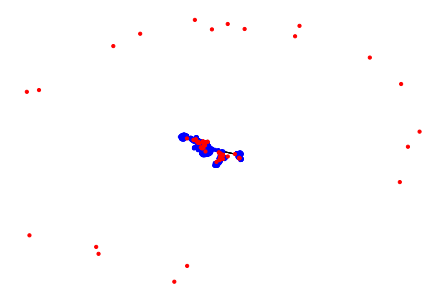

In [43]:
# create a dictionary to map node types to colors
type_colors = {"house": "blue", "school": "red"}

# create a list of node colors based on their type
node_colors = [type_colors[G_het.nodes[u]["node_type"]] for u in G_het.nodes()]

# draw the graph with node colors
pos = nx.spring_layout(G_het)
nx.draw(G_het, pos, node_color=node_colors, with_labels=False, node_size=10)

Filter out the dangling nodes of schools (won't be present if all schools are connected)

In [44]:
dangling_nodes = [n for n, d in G_het.degree() if d == 0]
print("Number of dangling nodes: ", len(dangling_nodes))
G_het.remove_nodes_from(dangling_nodes)
G_het.remove_edges_from(nx.selfloop_edges(G_het))

Number of dangling nodes:  20


Print out number of nodes per node type.

In [47]:
node_types = nx.get_node_attributes(G_het, "node_type")
type_count = {}

for node_type in node_types.values():
    if node_type in type_count:
        type_count[node_type] += 1
    else:
        type_count[node_type] = 1

print(type_count)

{'house': 1000, 'school': 80}


Create sparse adjacency matrix

In [ ]:
A = nx.to_scipy_sparse_matrix(G_het).astype("float32")
print(A)

## Attribute matrix preparation for house-school graph

- FeatureDES: type of school / Code represents FeatureDes in code format
- Name: name of school
- ABB_Name: the abbreviated name of the school
- OSPI_CODE: the code assigned by the Washington Office of Superintendent of Public Instruction (OSPI) to each school in the state

Unsure about:
- MAJOR: the major land use code for the parcel on which the school or facility is located
- MINOR: the minor land use code for the parcel on which the school or facility is located
- SCH_Classs: only has the value of 10 or 20, don't know what it exactly means.


In [49]:
print(school_df["FEATUREDES"].value_counts())
print(school_df["SCH_CLASS"].value_counts())

School-Elementary               45
School-Junior High/Middle       15
School-High                     12
School-Other Facility           12
School-Alternative              10
School-College or University     3
School-K-12                      3
Name: FEATUREDES, dtype: int64
10    89
20    11
Name: SCH_CLASS, dtype: int64


Filter out unnecessary columns

In [51]:
school_df = school_df[["FEATUREDES", "MAJOR", "MINOR", "SCH_CLASS"]]

,FEATUREDES,MAJOR,MINOR,SCH_CLASS
0,School-Elementary,322105,9058,10
16,School-College or University,242006,9046,10
21,School-Elementary,362104,9006,10
23,School-Elementary,262407,9047,10
29,School-Elementary,342406,9028,10


Create dummy encoding for the required columns. In this case all of them.

In [52]:
dummies_featuredes = pd.get_dummies(school_df['FEATUREDES'], prefix = "FEATUREDES")
dummies_major = pd.get_dummies(school_df['MAJOR'], prefix = "MAJOR")
dummies_minor = pd.get_dummies(school_df['MINOR'], prefix = "MINOR")
dummies_SCHClass = pd.get_dummies(school_df['SCH_CLASS'], prefix = "SCH_CLASS")

# Concatenate to one dataframe
school_vectorized = pd.concat([dummies_featuredes, dummies_major, dummies_minor, dummies_SCHClass], axis=1)
school_vectorized.head()

,FEATUREDES_School-Alternative,FEATUREDES_School-College or University,FEATUREDES_School-Elementary,FEATUREDES_School-High,FEATUREDES_School-Junior High/Middle,FEATUREDES_School-K-12,FEATUREDES_School-Other Facility,MAJOR_22005,MAJOR_42105,MAJOR_42606,...,MINOR_9112,MINOR_9113,MINOR_9114,MINOR_9123,MINOR_9134,MINOR_9144,MINOR_9156,MINOR_9192,SCH_CLASS_10,SCH_CLASS_20
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
16,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
21,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
23,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
29,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
31,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
34,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
47,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
51,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
55,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


Perform MinMaxScaler (for numerical features)

In [560]:
# scaler = MinMaxScaler()
# cols_to_scale = []
# school_df[cols_to_scale] = scaler.fit_transform(school_df[cols_to_scale])
# school_df.head()

Extract information on node type of heterogeneous graph

In [53]:
graph_dict = nx.get_node_attributes(G_het, "node_type")
graph_dict

{0.0: 'house',
 55.0: 'house',
 68.0: 'house',
 106.0: 'house',
 165.0: 'house',
 200.0: 'house',
 202.0: 'house',
 217.0: 'house',
 308.0: 'house',
 325.0: 'house',
 333.0: 'house',
 348.0: 'house',
 352.0: 'house',
 376.0: 'house',
 389.0: 'house',
 406.0: 'house',
 415.0: 'house',
 431.0: 'house',
 462.0: 'house',
 474.0: 'house',
 485.0: 'house',
 488.0: 'house',
 501.0: 'house',
 516.0: 'house',
 535.0: 'house',
 594.0: 'house',
 596.0: 'house',
 658.0: 'house',
 707.0: 'house',
 758.0: 'house',
 768.0: 'house',
 783.0: 'house',
 804.0: 'house',
 806.0: 'house',
 827.0: 'house',
 907.0: 'house',
 916.0: 'house',
 925.0: 'house',
 1076.0: 'house',
 1082.0: 'house',
 1108.0: 'house',
 1134.0: 'house',
 1145.0: 'house',
 1184.0: 'house',
 1195.0: 'house',
 1235.0: 'house',
 1267.0: 'house',
 1268.0: 'house',
 1288.0: 'house',
 1302.0: 'house',
 1322.0: 'house',
 1332.0: 'house',
 1333.0: 'house',
 1336.0: 'house',
 1344.0: 'house',
 1362.0: 'house',
 1368.0: 'house',
 1391.0: 'house'

Filter the dropped dangling nodes from the attribute matrices of schools and houses. (Won't be necessary if every node has at least one connection)

In [54]:
# houses = []
# schools = []

# for key, value in graph_dict.items():
#     if value == 'house':
#         houses.append(key)
#     elif value == 'school':
#         schools.append(key)

# print("houses: ", houses)
# print("houses_len", len(houses), " | df_houses_len", df_cleaned.shape[0])
# print("houses to remove: ", - len(houses) + df_cleaned.shape[0]) 
# print("*" * 100)
# print("schools: ", schools)
# print("schools_len", len(schools), " | df_schools_len", school_vectorized.shape[0]) 
# print("schools to remove: ", - len(schools) + school_vectorized.shape[0]) 

houses:  [0.0, 55.0, 68.0, 106.0, 165.0, 200.0, 202.0, 217.0, 308.0, 325.0, 333.0, 348.0, 352.0, 376.0, 389.0, 406.0, 415.0, 431.0, 462.0, 474.0, 485.0, 488.0, 501.0, 516.0, 535.0, 594.0, 596.0, 658.0, 707.0, 758.0, 768.0, 783.0, 804.0, 806.0, 827.0, 907.0, 916.0, 925.0, 1076.0, 1082.0, 1108.0, 1134.0, 1145.0, 1184.0, 1195.0, 1235.0, 1267.0, 1268.0, 1288.0, 1302.0, 1322.0, 1332.0, 1333.0, 1336.0, 1344.0, 1362.0, 1368.0, 1391.0, 1397.0, 1419.0, 1459.0, 1470.0, 1477.0, 1515.0, 1546.0, 1564.0, 1594.0, 1604.0, 1615.0, 1625.0, 1644.0, 1647.0, 1687.0, 1733.0, 1735.0, 1750.0, 1760.0, 1768.0, 1812.0, 1816.0, 1818.0, 1832.0, 1872.0, 1883.0, 1907.0, 1912.0, 1935.0, 1942.0, 1948.0, 1975.0, 1982.0, 1996.0, 2040.0, 2063.0, 2066.0, 2077.0, 2099.0, 2109.0, 2141.0, 2142.0, 2185.0, 2220.0, 2230.0, 2289.0, 2292.0, 2293.0, 2437.0, 2456.0, 2460.0, 2462.0, 2482.0, 2496.0, 2511.0, 2528.0, 2584.0, 2586.0, 2613.0, 2632.0, 2651.0, 2669.0, 2672.0, 2685.0, 2698.0, 2705.0, 2731.0, 2749.0, 2782.0, 2783.0, 2784.0, 

Subtract the offset from the school node IDs

Note: ONLY USE WHEN OFFSET WAS UTILIZED DURING EDGE CREATION

In [55]:
# original_school_ids = [school_id - offset for school_id in schools]
# df_houses_filtered = df[df.index.isin(houses)]
# df_schools_filtered = school_vectorized[school_vectorized.index.isin(original_school_ids)]
# print("new df houses shape: ", df_houses_filtered.shape)
# print("new df school shape: ", df_schools_filtered.shape)
#df_houses_filtered = df_houses_filtered.drop(["id", "price", "lat", "long", "index"], axis=1, inplace=False)

new df houses shape:  (1000, 20)
new df school shape:  (80, 137)


**GLACE**: necessary to utilize zero padding to create one large sparse attribute matrix.

Store the two feature matrices as one scipy sparse attribute matrix with following steps:
 1) Create two numpy arrays
 2) Use zero padding to make the numpy arrays have the same amount of columns
 3) Concatenate the two numpy arrays
 4) Convert this numpy array into one sparse attribute matrix

In [59]:
# Step 1: create two numpy arrays
houses_df_numpy = df_houses_filtered.to_numpy()
school_df_numpy = df_schools_filtered.to_numpy()

num_houses_vars = houses_df_numpy.shape[1]
num_schools_vars = school_df_numpy.shape[1]

# Step 2: create zero padding
if num_houses_vars == num_schools_vars:
    print("No zero padding necessary")
else: 
    # Create new numpy arrays with the correct shape and filled with zeros
    houses_padded = np.zeros((houses_df_numpy.shape[0], num_houses_vars + num_schools_vars))
    school_padded = np.zeros((school_df_numpy.shape[0], num_houses_vars + num_schools_vars))
    # Copy the original array to the new padded array
    houses_padded[:, :num_houses_vars] = houses_df_numpy
    school_padded[:,num_houses_vars:] = school_df_numpy
    
    # Print the shapes of the original and padded arrays for verification
    print("Original houses array shape:", houses_df_numpy.shape)
    print("Padded houses array shape:", houses_padded.shape)
    print("Original school array shape:", school_df_numpy.shape)
    print("Padded school array shape:", school_padded.shape)

# Step 3: Concatenate the two numpy arrays
df_concatenated = np.concatenate((houses_padded,school_padded), axis=0)
df_concatenated.shape

Original houses array shape: (1000, 15)
Padded houses array shape: (1000, 137)


(1080, 137)

In [60]:
# Step 4: Convert concatenated dataframe into a sparse attribute matrix
attr_matrix_concatenated = csr_matrix(df_concatenated).astype("float32")
attr_matrix_concatenated

<1080x137 sparse matrix of type '<class 'numpy.float32'>'
	with 11354 stored elements in Compressed Sparse Row format>

Save Heterogeneous graph file to be used by GLACE algorithm

In [62]:

np.savez('GLACE/graph2_school.npz', edges = G.edges, adj_data=A.data, adj_indices=A.indices, adj_indptr=A.indptr,
         adj_shape=A.shape, attr_data=attr_matrix.data, attr_indices=attr_matrix.indices, attr_indptr=attr_matrix.indptr,
         attr_shape=attr_matrix.shape,labels = labels)

**GSNE**: the sparse attribute matrices of houses and schools should be created separately

In [63]:
#Note: Not sure if houses_padded or standard house_df schould be used
attr_matrix_houses = csr_matrix(houses_padded).astype("float32")
attr_matrix_school = csr_matrix(school_df_numpy).astype("float32")

In [66]:
# Save heterogeneous graph file for GSNE
np.savez('GSNE_adjusted/Graph2.npz', edges = G_het.edges, adj_data=A.data, adj_indices=A.indices, adj_indptr=A.indptr,
         adj_shape=A.shape, attr_data1=attr_matrix_houses.data, attr_indices1=attr_matrix_houses.indices, attr_indptr1=attr_matrix_houses.indptr,
         attr_shape1=attr_matrix_houses.shape, attr_data2=attr_matrix_school.data, attr_indices2=attr_matrix_school.indices, attr_indptr2 = attr_matrix_school.indptr,
         attr_shape2=attr_matrix_school.shape, labels = labels)

# 3 - Complete heterogeneous graph file containing both House-House and House-School

The complete graph contains the house-house and house-school connections of the two previous graph files. 
This is a necessary graph file for the GSNE implementation

NOTE: THIS CODE IS EXPERIMENTAL

In [67]:
complete_graph = G.copy()
for node in G_het.nodes(data=True):
    complete_graph.add_node(node[0], **node[1])

for edge in G_het.edges(data=True):
    complete_graph.add_edge(edge[0], edge[1], **edge[2])

In [68]:
print("Number of edges house-house: ", len(G.edges()))
print("Number of edges house-school: ", len(G_het.edges()))
print("Number of edges: house-house and house-school", len(complete_graph.edges()))
print("Number of nodes: ", len(complete_graph.nodes()))

Number of edges house-house:  2185
Number of edges house-school:  6550
Number of edges: house-house and house-school 8735
Number of nodes:  1080


### Visualize complete graph

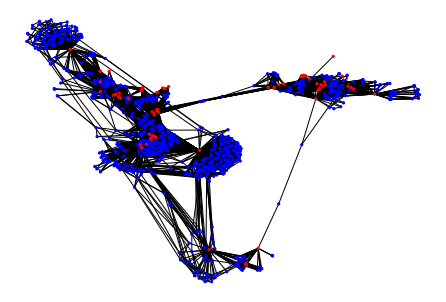

In [69]:
type_colors = {"house": "blue", "school": "red"}

node_colors = [type_colors[complete_graph.nodes[u]["node_type"]] for u in complete_graph.nodes()]

pos = nx.spring_layout(complete_graph)
nx.draw(complete_graph, pos, node_color=node_colors, with_labels=False, node_size=5)

The method "add_node()" in Networkx does not create duplicates if a node with the same identifier already exists in the network. 
As an extra precaution the code below verifies if there are duplicates. 

In [71]:
unique_nodes = len(set(G.nodes()) | set(G_het.nodes()))
if unique_nodes == len(complete_graph.nodes()):
    print("No duplicates found!")
else:
    print("Duplicates detected!")
    duplicates = [node for node in G.nodes() if node in G_het.nodes()]
    print("Duplicate nodes are:", duplicates)

No duplicates found!


Create adjacency matrix

This adjacency matrix contains all the connections of the two aforementioned graphs.

In [72]:
A = nx.to_scipy_sparse_matrix(complete_graph).astype("float32")

Create attribute matrix

In [ ]:
#Note: Not sure if houses_padded or standard house_df schould be used
attr_matrix_houses = csr_matrix(houses_padded).astype("float32")
attr_matrix_school = csr_matrix(school_df_numpy).astype("float32")

### Save graph file

In [73]:
np.savez('GSNE_adjusted/graph.npz', edges = complete_graph.edges, adj_data=A.data, adj_indices=A.indices, adj_indptr=A.indptr,
         adj_shape=A.shape, attr_data1=attr_matrix_houses.data, attr_indices1=attr_matrix_houses.indices, attr_indptr1=attr_matrix_houses.indptr,
         attr_shape1=attr_matrix_houses.shape, attr_data2=attr_matrix_school.data, attr_indices2=attr_matrix_school.indices, attr_indptr2 = attr_matrix_school.indptr,
         attr_shape2=attr_matrix_school.shape, labels = labels)